In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('data/ner_dataset.csv', encoding='latin1')
data = data.fillna(method='ffill')

In [2]:
class SentenceGetter:
    def __init__(self, data):
        self.pos = 1
        self.data = data
        self.empty = False
        
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s.Word.tolist(),
                                                          s.POS.tolist(),
                                                          s.Tag.tolist())]
        
        self.grouped = self.data.groupby('Sentence #').apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def reset(self):
        self.pos = 1
        
    def get_next(self):
        try:
            s = self.grouped['Sentence: {}'.format(self.pos)]
            self.pos += 1
            return s
        except:
            return None

In [3]:
data.tail(10)

,Sentence #,Word,POS,Tag
1048565,Sentence: 47958,impact,NN,O
1048566,Sentence: 47958,.,.,O
1048567,Sentence: 47959,Indian,JJ,B-gpe
1048568,Sentence: 47959,forces,NNS,O
1048569,Sentence: 47959,said,VBD,O
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


In [4]:
words = set(data.Word.tolist())
PADDING = 'PADDING'
words.add(PADDING)
n_words = len(words)

tags = set(data.Tag.tolist())
n_tags = len(tags)

print('words: {n_words} tags: {n_tags}'.format(n_words=n_words, n_tags=n_tags))

words: 35179 tags: 17


In [5]:
getter = SentenceGetter(data)

In [6]:
sentences = getter.sentences
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

In [7]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.hist([len(s) for s in sentences], bins=100)
plt.show()

<Figure size 640x480 with 1 Axes>

In [8]:
max_len = 75
word2idx = {w:i for i, w in enumerate(words)}
tag2idx = {t:i for i, t in enumerate(tags)}

In [9]:
print(word2idx['Obama'])
print(tag2idx['B-geo'])

25362
2


In [10]:
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [11]:
y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding='post', value=tag2idx['O'])
y[0]

array([1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 6, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [12]:
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding='post', value=n_words-1)

In [13]:
from keras.utils import to_categorical

In [14]:
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [19]:
print(X_train[0])
print(y_train[0])

[20235   594 12543 25761  6851 27007 13669 18848  8073 24026 26173 21661
 13669  3342 26903 12083 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178]
[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [16]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
import keras_metrics

In [17]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words+1, 
                  output_dim=20, 
                  input_length=max_len,
                  mask_zero=True)(input)
model = Bidirectional(LSTM(units=50, 
                           return_sequences=True, 
                           recurrent_dropout=0.1))(model)
model = TimeDistributed(Dense(50, activation='relu'))(model)
crf = CRF(n_tags)
out = crf(model)

model = Model(input, out)
model.compile(optimizer='rmsprop', 
              loss=crf.loss_function, 
              metrics=[crf.accuracy])

/Users/kyouyeolhan/anaconda3/lib/python3.6/site-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/Users/kyouyeolhan/anaconda3/lib/python3.6/site-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 75, 20)            703600    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 75, 100)           28400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 75, 50)            5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 75, 17)            1190      
Total params: 738,240
Trainable params: 738,240
Non-trainable params: 0
_________________________________________________________________


In [19]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [20]:
history = model.fit(X_train, np.array(y_train), batch_size=64, epochs=5,
                    validation_split=0.1, verbose=1)

Train on 38846 samples, validate on 4317 samples
Epoch 1/5
38846/38846 [==============================] - 101s 3ms/step - loss: 0.1484 - crf_viterbi_accuracy: 0.9635 - val_loss: 0.0618 - val_crf_viterbi_accuracy: 0.9817
Epoch 2/5
38846/38846 [==============================] - 100s 3ms/step - loss: 0.0428 - crf_viterbi_accuracy: 0.9865 - val_loss: 0.0336 - val_crf_viterbi_accuracy: 0.9883
Epoch 3/5
38846/38846 [==============================] - 101s 3ms/step - loss: 0.0279 - crf_viterbi_accuracy: 0.9900 - val_loss: 0.0269 - val_crf_viterbi_accuracy: 0.9899
Epoch 4/5
38846/38846 [==============================] - 101s 3ms/step - loss: 0.0230 - crf_viterbi_accuracy: 0.9913 - val_loss: 0.0246 - val_crf_viterbi_accuracy: 0.9901
Epoch 5/5
38846/38846 [==============================] - 101s 3ms/step - loss: 0.0204 - crf_viterbi_accuracy: 0.9919 - val_loss: 0.0227 - val_crf_viterbi_accuracy: 0.9907


In [57]:
hist = pd.DataFrame(history.history)

In [58]:
hist

,val_loss,val_crf_viterbi_accuracy,loss,crf_viterbi_accuracy
0,0.034460,0.985170,0.027592,0.988736
1,0.034646,0.985323,0.025385,0.989292
2,0.034401,0.985041,0.023859,0.989825
3,0.033126,0.985504,0.022560,0.990326
4,0.033341,0.984999,0.021486,0.990738


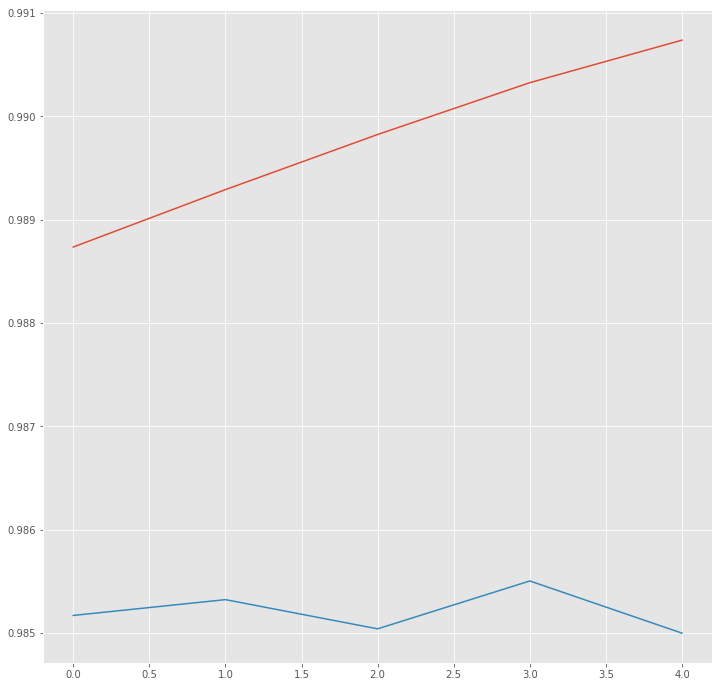

In [59]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["crf_viterbi_accuracy"])
plt.plot(hist["val_crf_viterbi_accuracy"])
plt.show()

In [60]:
y_pred = model.predict(X_test, verbose=True)

4796/4796 [==============================] - 4s 772us/step


In [61]:
idx2tag = {i:w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace('PAD', 'O'))
        out.append(out_i)
    return out

pred_label = pred2label(y_pred)
test_label = pred2label(y_test)

In [62]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

print("F1-score: {:.1%}".format(f1_score(test_label, pred_label)))
print(classification_report(test_label, pred_label))

F1-score: 83.2%
             precision    recall  f1-score   support

        geo       0.86      0.88      0.87      3811
        gpe       0.98      0.92      0.95      1634
        nat       0.50      0.05      0.08        22
        per       0.77      0.77      0.77      1679
        org       0.70      0.72      0.71      1993
        tim       0.88      0.84      0.86      2047
        eve       0.31      0.14      0.20        28
        art       0.00      0.00      0.00        42

avg / total       0.84      0.83      0.83     11256



In [63]:
idx2word = {i:w for w, i in word2idx.items()}

i = 1927
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_test[i], -1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_test[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(idx2word[w-1], idx2tag[t], idx2tag[pred]))


Word           ||True ||Pred
pro-U.S.-immigration: O     O
painkiller     : O     O
sustained      : O     O
Ouyang         : O     O
Mart           : O     O
bathtub        : O     O
Eastern        : O     O
Baden-Baden    : O     O
Odyssey        : O     O
mischief       : O     O
Akwa           : O     O
nuclear-powered: O     O
Migratory      : O     O
factories      : B-geo B-geo
exploration    : O     O
meteorological : O     O
Tashkent       : O     O
Eastern        : O     O
aggressions    : O     O
ladder         : O     O
Eskisehir      : O     O
Pedro          : O     O
Pedro          : O     O
Pedro          : O     O
Pedro          : O     O
Pedro          : O     O
Pedro          : O     O
Pedro          : O     O
Pedro          : O     O
Pedro          : O     O
Pedro          : O     O
Pedro          : O     O
Pedro          : O     O
Pedro          : O     O
Pedro          : O     O
Pedro          : O     O
Pedro          : O     O
Pedro          : O     O
Pedro       